## hardware

In [1]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: AuthenticAMD
cpu family	: 23
model		: 49
model name	: AMD EPYC 7452 32-Core Processor
stepping	: 0
microcode	: 0x830107a
cpu MHz		: 1500.000
cache size	: 512 KB
physical id	: 0
siblings	: 64
core id		: 0
cpu cores	: 32
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 16
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ht syscall nx mmxext fxsr_opt pdpe1gb rdtscp lm constant_tsc rep_good nopl nonstop_tsc cpuid extd_apicid aperfmperf rapl pni pclmulqdq monitor ssse3 fma cx16 sse4_1 sse4_2 movbe popcnt aes xsave avx f16c rdrand lahf_lm cmp_legacy svm extapic cr8_legacy abm sse4a misalignsse 3dnowprefetch osvw ibs skinit wdt tce topoext perfctr_core perfctr_nb bpext perfctr_llc mwaitx cpb cat_l3 cdp_l3 hw_pstate ssbd mba ibrs ibpb stibp vmmcall fsgsbase bmi1 avx2 smep bmi2 cqm rdt_a rdseed adx smap clflushopt clwb sha_ni xsaveopt xsavec xgetbv1 cqm_llc cqm_occup_llc cqm_

In [2]:
!nvidia-smi

Mon Oct  7 17:24:19 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.76                 Driver Version: 550.76         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        On  |   00000000:82:00.0 Off |                  N/A |
| 33%   28C    P8             21W /  350W |       1MiB /  24576MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## library

In [3]:
!pip install scikit-learn matplotlib pandas
!pip install albumentations pydicom segmentation_models_pytorch timm transformers

In [4]:
import numpy as np
import pandas as pd

import random

import os

import glob

from tqdm import tqdm

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

import json

import matplotlib.pyplot as plt

import cv2

import shutil

import torch
import torch.nn as nn
import torch.nn.functional as F

import albumentations as A

import pydicom

import timm
import gc


from transformers.optimization import AdamW, get_cosine_schedule_with_warmup

from scipy.ndimage import gaussian_filter

from segmentation_models_pytorch.decoders.unet.model import (
    UnetDecoder,
    SegmentationHead,
)
DATA_DIR = '/sys/fs/cgroup/data'

## config

In [5]:
class CustomConfig:
    seed = 42
    device = 'cuda'
    root = DATA_DIR

    train = pd.read_csv(f'{DATA_DIR}/train.csv')
    label_columns = train.columns[1:]

    ignore_index = -100
    label2index = {'Normal/Mild' : 0, 'Moderate' : 1, 'Severe' : 2, 'Nan' : ignore_index,}
    label2onehot = {'Normal/Mild' : [1, 0, 0], 'Moderate' : [0, 1, 0], 'Severe' : [0, 0, 1], 'Nan' : [ignore_index] * 3,}
    label2weight = {'Normal/Mild' : 1, 'Moderate' : 2, 'Severe' : 4, 'Nan' : 0,}

    scan_orientations = ['Sagittal T2/STIR', 'Sagittal T1', 'Axial T2']

    n_class = 3
    n_fold = 5
    
    version = 1

    batch_size = 4
    n_worker = 16
    iters_to_accumulate = 1#1

    lr = 1e-4
    wd = 1e-2
    n_epoch = 10
    warmup_ratio = 0.1
    test_freq = 1

    mix_method = 'cutmix'
    mix_prob = 1.0
    mix_alpha = 4.0

    patch_size = 32
    image_size = 128
    depth_size = 1 + 2*2

    weight_loss = True
    any_loss = True

    coordinate_columns = {
        'Sagittal T2/STIR' : [
            ['Spinal Canal Stenosis', 'L1/L2'],
            ['Spinal Canal Stenosis', 'L2/L3'],
            ['Spinal Canal Stenosis', 'L3/L4'],
            ['Spinal Canal Stenosis', 'L4/L5'],
            ['Spinal Canal Stenosis', 'L5/S1'],
        ],
        'Sagittal T1' : [
            ['Left Neural Foraminal Narrowing', 'L1/L2'],
            ['Left Neural Foraminal Narrowing', 'L2/L3'],
            ['Left Neural Foraminal Narrowing', 'L3/L4'],
            ['Left Neural Foraminal Narrowing', 'L4/L5'],
            ['Left Neural Foraminal Narrowing', 'L5/S1'],

            ['Right Neural Foraminal Narrowing', 'L1/L2'],
            ['Right Neural Foraminal Narrowing', 'L2/L3'],
            ['Right Neural Foraminal Narrowing', 'L3/L4'],
            ['Right Neural Foraminal Narrowing', 'L4/L5'],
            ['Right Neural Foraminal Narrowing', 'L5/S1'],
        ],
        'Axial T2' : [
            ['Left Subarticular Stenosis', 'L1/L2'],
            ['Left Subarticular Stenosis', 'L2/L3'],
            ['Left Subarticular Stenosis', 'L3/L4'],
            ['Left Subarticular Stenosis', 'L4/L5'],
            ['Left Subarticular Stenosis', 'L5/S1'],

            ['Right Subarticular Stenosis', 'L1/L2'],
            ['Right Subarticular Stenosis', 'L2/L3'],
            ['Right Subarticular Stenosis', 'L3/L4'],
            ['Right Subarticular Stenosis', 'L4/L5'],
            ['Right Subarticular Stenosis', 'L5/S1'],
        ],
    }

if __name__ == "__main__":
    args = CustomConfig()

## seed

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

if __name__ == "__main__":
    seed_everything(args.seed)

## preprocess

In [7]:
def preprocess(args):
    train = pd.read_csv(f'{DATA_DIR}/train.csv')

    folds = []

    kf = KFold(n_splits = args.n_fold, shuffle = True, random_state = args.seed)
    for train_indices, test_indices in kf.split(train):

        train_df = train.loc[train_indices].reset_index(drop = True)
        test_df = train.loc[test_indices].reset_index(drop = True)

        folds.append([train_df, test_df])

    stage1_results = [
        np.concatenate([
            np.load(f'{DATA_DIR}/stage1/coordinates/sgittal_t2_fold{fold+1}_preds2.npy')
                        for fold in range(5)
        ], axis = 0),

        np.concatenate([
            np.load(f'{DATA_DIR}/stage1/coordinates/sgittal_t1_fold{fold+1}_preds2.npy')
                        for fold in range(5)
        ], axis = 0),

        np.concatenate([
            np.load(f'{DATA_DIR}/stage1/coordinates/axial_t2_fold{fold+1}_preds2.npy')
                        for fold in range(5)
        ], axis = 0)
    ]

    df = pd.concat([
        folds[fold][1] for fold in range(5)
    ], axis = 0)
    df = df.reset_index(drop = True)

    detects = {}
    for i in range(len(df)):
        row = df.loc[i]
        detects[row.study_id] = {}
        detects[row.study_id][args.scan_orientations[0]] = stage1_results[0][i]
        detects[row.study_id][args.scan_orientations[1]] = stage1_results[1][i]
        detects[row.study_id][args.scan_orientations[2]] = stage1_results[2][i]

    return train, folds, detects

if __name__ == "__main__":
    train, folds, detects = preprocess(args)

## dataset

In [8]:
class CustomTransform(nn.Module):
    def __init__(self, args, mode = 'test'):
        super(CustomTransform, self).__init__()

        if mode == 'train':
            self.transform = A.Compose([
                A.Resize(args.image_size, args.image_size, p = 1.0),
                A.HorizontalFlip(p = 0.5),
                A.VerticalFlip(p = 0.5),
                A.ShiftScaleRotate(border_mode = cv2.BORDER_CONSTANT, p = 0.75),
                A.RandomBrightnessContrast(p = 0.75),
            ])
        else:
            self.transform = A.Compose([
                A.Resize(args.image_size, args.image_size, p = 1.0),
            ])

    def forward(self, x):
        x = x.transpose(1, 2, 0)
        x = self.transform(image = x)['image']
        x = x.transpose(2, 0, 1)
        x = torch.tensor(x, dtype = torch.float)
        return x

def get_global_weights(args, df):
    weights = np.zeros([len(df), len(args.label_columns)], dtype = np.float32)
    for i in range(weights.shape[0]):
        row = df.loc[i]

        label = row[args.label_columns]
        label = label.fillna('Nan')
        label = label.values

        for j in range(weights.shape[1]):
            weights[i, j] = args.label2weight[label[j]]

    spinal_weight = weights[:, 0:5]
    spinal_weight = spinal_weight / spinal_weight.sum()
    spinal_weight = spinal_weight * spinal_weight.size

    foraminal_weight = weights[:, 5:15]
    foraminal_weight = foraminal_weight / foraminal_weight.sum()
    foraminal_weight = foraminal_weight * foraminal_weight.size

    subarticular_weight = weights[:, 15:25]
    subarticular_weight = subarticular_weight / subarticular_weight.sum()
    subarticular_weight = subarticular_weight * subarticular_weight.size

    any_severe_spinal_weight = weights[:, 0:5].max(axis = 1, keepdims = True)
    any_severe_spinal_weight = any_severe_spinal_weight / any_severe_spinal_weight.sum()
    any_severe_spinal_weight = any_severe_spinal_weight * any_severe_spinal_weight.size

    weights = np.concatenate([spinal_weight, foraminal_weight, subarticular_weight, any_severe_spinal_weight], axis = 1)
    return weights

inputs :  torch.Size([25, 5, 128, 128])
targets :  tensor([0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1,
        0])
weights :  tensor([0.8228, 0.8228, 0.8228, 3.2913, 0.8228, 0.7763, 0.7763, 0.7763, 0.7763,
        0.7763, 0.7763, 0.7763, 0.7763, 0.7763, 0.7763, 0.6959, 0.6959, 0.6959,
        2.7834, 0.6959, 0.6959, 0.6959, 0.6959, 1.3917, 0.6959, 2.3295])


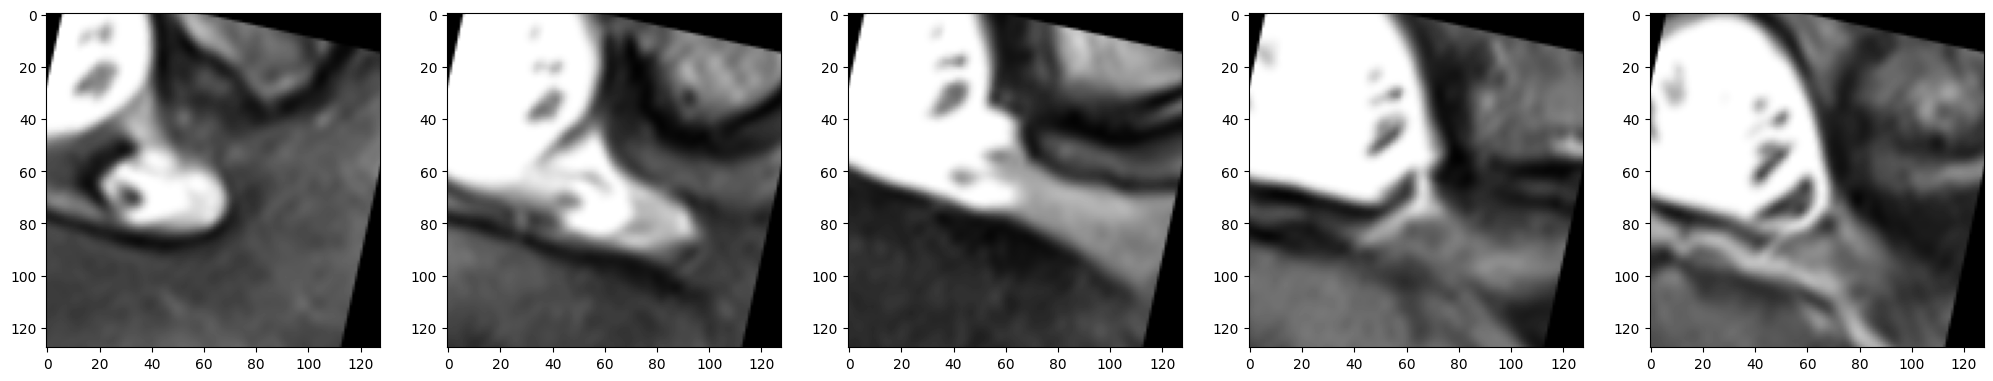

Sagittal T2/STIR :  torch.Size([5, 5, 128, 128])
Sagittal T1 :  torch.Size([10, 5, 128, 128])
Axial T2 :  torch.Size([10, 5, 128, 128])


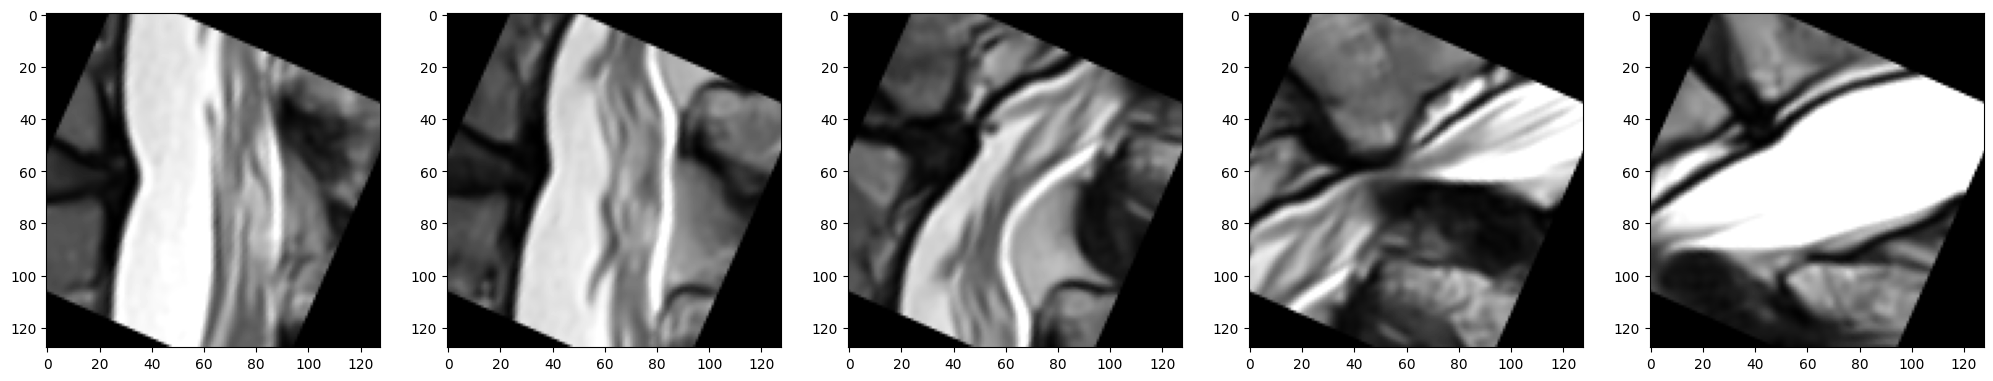

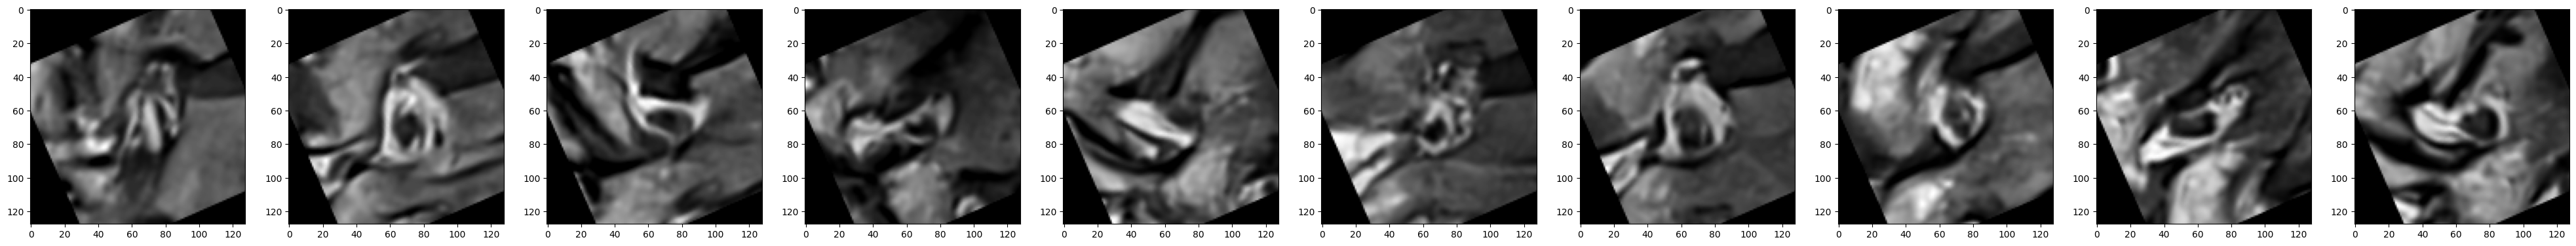

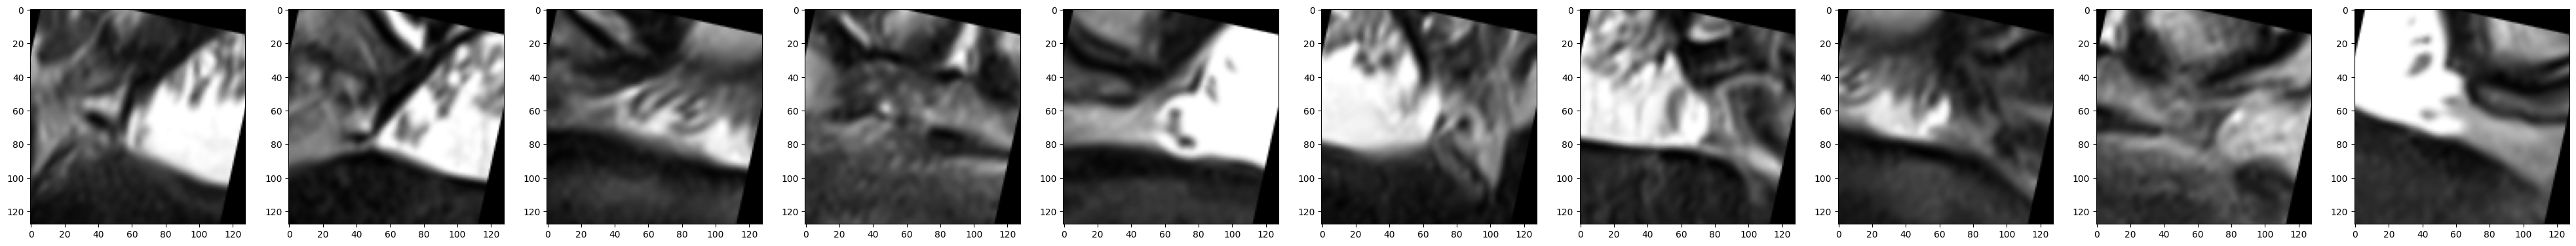

In [9]:
def convert_to_8bit(x):
    lower, upper = np.percentile(x, (1, 99))
    x = np.clip(x, lower, upper)
    x = x - np.min(x)
    x = x / np.max(x)
    return (x * 255).astype("uint8")

def get_imgs(dcms):
    imgs = []
    for dcm in dcms:
        img = convert_to_8bit(dcm.pixel_array)
        imgs.append(img)

    try:
        return np.stack(imgs, axis = 0)
    except:
        h, w = imgs[0].shape
        imgs = [A.Resize(h, w)(image = x)['image'] for x in imgs]
        return np.stack(imgs, axis = 0)

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self,
                 args,
                 df,
                 detects,
                 mode = 'test',
                 ):
        self.args = args
        self.df = df
        self.detects = detects

        self.mode = mode

        self.transform = CustomTransform(args, self.mode)

        self.volume_sizes = {
            'Sagittal T2/STIR' : [29, 512, 512],
            'Sagittal T1' : [38, 512, 512],
            'Axial T2' : [192, 512, 512]
        }

        self.train_series_descriptions = pd.read_csv(f'{DATA_DIR}/train_series_descriptions.csv')
        self.train_label_coordinates = pd.read_csv(f'{DATA_DIR}/train_label_coordinates.csv')

        self.weights = get_global_weights(args, df)

    def __len__(self):
        return len(self.df)
    

    def get_subvolume(self, study_id, series_id, orientation):
        dicoms = sorted(glob.glob(self.args.root + f'/train_images/{study_id}/{series_id}/*.dcm'), key = lambda x: int(x.split('/')[-1].split('.')[0]))     
        dicoms = [pydicom.dcmread(x) for x in dicoms]
        
        if 'Sagittal' in orientation:
            pos = np.asarray([dicom.ImagePositionPatient for dicom in dicoms])[:, 0]
        else:
            pos = np.asarray([dicom.ImagePositionPatient for dicom in dicoms])[:, -1]
            orien = np.asarray([dicom.ImageOrientationPatient for dicom in dicoms])


        inputs = get_imgs(dicoms)
        inputs = A.Resize(self.volume_sizes[orientation][1], self.volume_sizes[orientation][2])(image = inputs.transpose(1, 2, 0))['image'].transpose(2, 0, 1)
        inputs = torch.tensor(inputs, dtype = torch.float)
        inputs = inputs / 255.0

        return inputs, pos

    def get_volume(self, row, orientation):
        row_series_descriptions = self.train_series_descriptions[self.train_series_descriptions['study_id'] == row['study_id']]
        row_series_descriptions = row_series_descriptions[row_series_descriptions['series_description'] == orientation].reset_index(drop = True)
        
        
        if len(row_series_descriptions) > 0:
            inputs, pos = [], []
            for i in range(len(row_series_descriptions)):
                study_id, series_id, _ = row_series_descriptions.loc[i]
                
                _inputs, _pos = self.get_subvolume(study_id, series_id, orientation)
                inputs.append(_inputs)
                pos.append(_pos)

            inputs = torch.cat(inputs, dim = 0)
            pos = np.concatenate(pos, axis = 0)
        else:
            inputs = torch.zeros(self.volume_sizes[orientation], dtype = torch.float32)
            pos = np.zeros([self.volume_sizes[orientation][0]], dtype = np.float32)

        pos = np.argsort(pos)
        inputs = inputs[pos]

        if inputs.shape[0] > self.volume_sizes[orientation][0]:
            inputs = F.interpolate(inputs.unsqueeze(0).unsqueeze(0), size = self.volume_sizes[orientation], mode = 'trilinear').squeeze(0).squeeze(0)
        return inputs

    def get_inputs(self, row):
        row_series_descriptions = self.train_series_descriptions[self.train_series_descriptions['study_id'] == row['study_id']]

        inputs = []
        for orientation in args.scan_orientations:
            if orientation in list(row_series_descriptions['series_description']):
                volume = self.get_volume(row, orientation)
                detect = self.detects[row['study_id']][orientation]


                crops = []
                for i in range(detect.shape[0]):
                    z = detect[i][0] * 1
                    z_all = range(z-2, z+3)
                    y_all = detect[i][1:10] * 2
                    x_all = detect[i][10:20] * 2

                    y_all, x_all = y_all[2:-2], x_all[2:-2]

                    crop = []
                    for z, y, x in zip(z_all, y_all, x_all):

                        # z_start, z_end = max(z - (self.args.depth_size - 1)//2, 0), min(z + (self.args.depth_size - 1)//2 + 1, self.volume_sizes[orientation][0])
                        z = min(max(z, 0), volume.shape[0]-1)
                        y_start, y_end = y - self.args.patch_size, y + self.args.patch_size
                        if y_start<0:
                            y_start, y_end = 0, 2*self.args.patch_size
                        if y_end>=self.volume_sizes[orientation][1]:
                            y_start, y_end = self.volume_sizes[orientation][1]-1 - 2*self.args.patch_size, self.volume_sizes[orientation][1]-1

                        x_start, x_end = x - self.args.patch_size, x + self.args.patch_size
                        if x_start<0:
                            x_start, x_end = 0, 2*self.args.patch_size
                        if x_end>=self.volume_sizes[orientation][2]:
                            x_start, x_end = self.volume_sizes[orientation][2]-1 - 2*self.args.patch_size, self.volume_sizes[orientation][2]-1

                        crop.append(volume[z, y_start:y_end, x_start:x_end])
                
                    crop = torch.stack(crop, dim = 0)

                    
                    # crop = F.interpolate(crop.unsqueeze(0).unsqueeze(0), size = [self.args.depth_size, 2*self.args.patch_size, 2*self.args.patch_size], mode = 'trilinear').squeeze(0).squeeze(0)
                    crop = crop.numpy()

                    crops.append(crop)
                crops = np.concatenate(crops, axis = 0)
            else:
                crops = np.zeros([self.args.depth_size * len(self.args.coordinate_columns[orientation]), 2*self.args.patch_size, 2*self.args.patch_size])

            crops = crops.astype(np.float32)
            crops = self.transform(crops)
            crops = crops.reshape(-1, self.args.depth_size, self.args.image_size, self.args.image_size)
            inputs.append(crops)

        inputs = np.concatenate(inputs, axis = 0)
        inputs = torch.tensor(inputs, dtype = torch.float)
        return inputs

    def get_targets(self, row):
        label = row[self.args.label_columns]
        label = label.fillna('Nan')

        targets = [self.args.label2index[x] for x in label]
        targets = torch.tensor(targets, dtype = torch.long)
        return targets

    def get_weights(self, index):
        weights = self.weights[index]
        weights = torch.tensor(weights, dtype = torch.float)
        return weights

    def __getitem__(self, index):
        row = self.df.loc[index]

        inputs = self.get_inputs(row)
        targets = self.get_targets(row)
        weights = self.get_weights(index)
        
        return inputs, targets, weights

if __name__ == "__main__":
    train_df, test_df = folds[0]

    mode = 'train'

    df = train_df if mode == 'train' else test_df
    dataset = CustomDataset(args, df, detects, mode)

    index = random.randint(0, len(dataset) - 1)
    inputs, targets, weights = dataset[index]

    print('inputs : ', inputs.shape)
    print('targets : ', targets)
    print('weights : ', weights)

    index = random.randint(0, inputs.shape[0] - 1)
    volume = inputs[index]
    fig, axes = plt.subplots(1, volume.shape[0], figsize = (5 * volume.shape[0], 5))
    for i in range(volume.shape[0]):
        x = volume[i]
        axes[i].imshow(x, cmap = 'gray')
    plt.show()

    inputs1, inputs2, inputs3 = inputs[0:5], inputs[5:15], inputs[15:25]

    print('Sagittal T2/STIR : ', inputs1.shape)
    print('Sagittal T1 : ', inputs2.shape)
    print('Axial T2 : ', inputs3.shape)

    for inputs in [inputs1, inputs2, inputs3]:
        fig, axes = plt.subplots(1, inputs.shape[0], figsize = (5 * inputs.shape[0], 5))
        for i in range(inputs.shape[0]):
            x = inputs[i]
            axes[i].imshow(x[x.shape[0]//2], cmap = 'gray')
    plt.show()

## model

In [10]:
class FeatureExtractor(nn.Module):
    def __init__(self, n_channel, hidden_size):
        super(FeatureExtractor, self).__init__()
        self.backbone = timm.create_model(
            model_name = 'convnext_small.in12k_ft_in1k',
            pretrained = True,
            num_classes = 0,
            in_chans = n_channel
            )

    def forward(self, x):
        x = self.backbone(x)
        return x

################################################################################
class CustomPooler(nn.Module):
    def __init__(self, hidden_size):
        super(CustomPooler, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size, bias = True),
            nn.Tanh(),
            nn.Linear(hidden_size, 1, bias = False),
            nn.Softmax(dim = 1),
        )

    def forward(self, x):
        _x = self.fc(x)
        x = torch.sum(x * _x, dim = 1)
        return x
################################################################################

class CustomModel(nn.Module):
    def __init__(self,
                 args,
                 n_channel = 1,
                 hidden_size = 768,
                 drop_rate = 0.2
                 ):

        super(CustomModel, self).__init__()
        self.args = args
        
        self.version = args.version

        self.hidden_size = hidden_size
        self.drop_rate = drop_rate

        self.cnn = FeatureExtractor(
            n_channel = n_channel,
            hidden_size = hidden_size,
            )

        self.rnn1 = nn.LSTM(
            input_size = hidden_size,
            #hidden_size = hidden_size//4,
            ####################################################################
            hidden_size = hidden_size//2,
            ####################################################################
            batch_first = True,
            bidirectional = True
            )

        ########################################################################
        self.pooler = CustomPooler(
            hidden_size = hidden_size,
            )
        ########################################################################

        self.rnn2 = nn.LSTM(
            input_size = hidden_size,
            hidden_size = hidden_size//2,
            batch_first = True,
            bidirectional = True
            )

        self.out1 = nn.Sequential(
            nn.Dropout(drop_rate),
            nn.Linear(hidden_size, args.n_class)
        )
        self.out2 = nn.Sequential(
            nn.Dropout(drop_rate),
            nn.Linear(hidden_size, args.n_class)
        )
        self.out3 = nn.Sequential(
            nn.Dropout(drop_rate),
            nn.Linear(hidden_size, args.n_class)
        )

    def initialize(self):
        self.out1 = nn.Sequential(
            nn.Dropout(self.drop_rate),
            nn.Linear(self.hidden_size, self.args.n_class)
        )
        self.out2 = nn.Sequential(
            nn.Dropout(self.drop_rate),
            nn.Linear(self.hidden_size, self.args.n_class)
        )
        self.out3 = nn.Sequential(
            nn.Dropout(self.drop_rate),
            nn.Linear(self.hidden_size, self.args.n_class)
        )

    def forward(self, x):
        with torch.no_grad():
            _, _, d, h, w = x.shape

            x = x.reshape(-1, h, w)
            x = x.unsqueeze(1)
            x = self.cnn(x)

            if self.version == 1:
                x = x.reshape(-1, d, self.hidden_size)
                x, _ = self.rnn1(x)
                x = self.pooler(x)
                x = x.reshape(-1, 25, self.hidden_size)
                x = x.reshape(-1, 5, 5, self.hidden_size)
                x = x.permute(0, 2, 1, 3)
                x = x.reshape(-1, 5, self.hidden_size)
                x, _ = self.rnn2(x)

            elif self.version == 2:
                x = x.reshape(-1, d, self.hidden_size)
                x, _ = self.rnn1(x)
                x = self.pooler(x)
                x = x.reshape(-1, 25, self.hidden_size)
                x = x.reshape(-1, 5, 5, self.hidden_size)
                x = x.permute(0, 2, 1, 3)
                x = x.reshape(-1, 5, self.hidden_size)
                x_, _ = self.rnn2(x)
                x = x + x_

            elif self.version == 3:
                x = x.reshape(-1, 5, 5, d, self.hidden_size)
                x = x.permute(0, 2, 1, 3, 4)
                x = x.reshape(-1, 5 * d, self.hidden_size)
                x, _ = self.rnn1(x)
                x = x.reshape(-1, d, self.hidden_size)
                x = self.pooler(x)

            x = x.reshape(-1, 5, 5, self.hidden_size)
            x = x.permute(0, 2, 1, 3)
            x = x.reshape(-1, 25, self.hidden_size)


            x1 = x[:, 0:5]
            x2 = x[:, 5:15]
            x3 = x[:, 15:25]

        x1 = self.out1(x1)
        x2 = self.out2(x2)
        x3 = self.out3(x3)

        x = torch.cat([x1, x2, x3], dim = 1)
        return x

if __name__ == "__main__":
    loader = torch.utils.data.DataLoader(dataset, batch_size = args.batch_size, num_workers = args.n_worker)
    sample = next(iter(loader))
    sample = [x.to(args.device) for x in sample]

    model = CustomModel(args)
    model = model.to(args.device)

    with torch.no_grad():
        outputs = model(sample[0])
        print(outputs.shape)

torch.Size([4, 25, 3])


## loss

In [11]:
class CustomLoss(nn.Module):
    def __init__(self, args):
        super(CustomLoss, self).__init__()
        self.args = args

        self.ce_loss = nn.CrossEntropyLoss(reduction = 'none')
        self.bce_loss = nn.BCELoss(reduction = 'none')

        self.softmax = nn.Softmax(dim = -1)

        self.severe_index = args.label2index['Severe']

    def forward(self, preds, trues, weights):
        if not self.args.weight_loss:
            weights = (weights!=0).float()

        spinal_pred = preds[:, 0:5, :].reshape(-1, self.args.n_class)
        spinal_true = trues[:, 0:5].reshape(-1)
        spinal_weight = weights[:, 0:5].reshape(-1)
        spinal_loss = self.ce_loss(spinal_pred, spinal_true)

        foraminal_pred = preds[:, 5:15, :].reshape(-1, self.args.n_class)
        foraminal_true = trues[:, 5:15].reshape(-1)
        foraminal_weight = weights[:, 5:15].reshape(-1)
        foraminal_loss = self.ce_loss(foraminal_pred, foraminal_true)

        subarticular_pred = preds[:, 15:25, :].reshape(-1, self.args.n_class)
        subarticular_true = trues[:, 15:25].reshape(-1)
        subarticular_weight = weights[:, 15:25].reshape(-1)
        subarticular_loss = self.ce_loss(subarticular_pred, subarticular_true)

        any_severe_spinal_true = ((trues[:, 0:5] == self.severe_index).sum(1) != 0).float()
        any_severe_spinal_pred, _ = self.softmax(preds)[:, 0:5, self.severe_index].max(1)
        any_severe_spinal_weight = weights[:, 25]
        any_severe_spinal_loss = self.bce_loss(any_severe_spinal_pred, any_severe_spinal_true)

        spinal_loss = (spinal_loss * spinal_weight).mean()
        foraminal_loss = (foraminal_loss * foraminal_weight).mean()
        subarticular_loss = (subarticular_loss * subarticular_weight).mean()
        any_severe_spinal_loss = (any_severe_spinal_loss * any_severe_spinal_weight).mean()

        if self.args.any_loss:
            loss = (spinal_loss + foraminal_loss + subarticular_loss + any_severe_spinal_loss) / 4
        else:
            loss = (spinal_loss + foraminal_loss + subarticular_loss) / 3
        return loss

if __name__ == "__main__":
    loader = torch.utils.data.DataLoader(dataset, batch_size = args.batch_size, num_workers = args.n_worker)
    sample = next(iter(loader))
    sample = [x.to(args.device) for x in sample]

    model = CustomModel(args)
    model = model.to(args.device)

    loss_fn = CustomLoss(args)

    with torch.no_grad():
        outputs = model(sample[0])
        loss = loss_fn(outputs, sample[1], sample[2])
        print(loss)

tensor(0.9563, device='cuda:0')


## utils

In [12]:
def get_solution(args, df):
    row_id = []
    normal_mild = []
    moderate = []
    severe = []
    sample_weight = []

    for i in range(len(df)):
        x = df.loc[i]
        x = x.fillna('Nan')

        for j in range(len(args.label_columns)):
            label = x[args.label_columns[j]]
            onehot = args.label2onehot[label]
            weight = args.label2weight[label]

            row_id.append(f'{x.study_id}_{args.label_columns[j]}')
            normal_mild.append(onehot[0])
            moderate.append(onehot[1])
            severe.append(onehot[2])
            sample_weight.append(weight)

    solution = pd.DataFrame()

    solution['row_id'] = row_id
    solution['normal_mild'] = normal_mild
    solution['moderate'] = moderate
    solution['severe'] = severe
    solution['sample_weight'] = sample_weight
    return solution

def get_submission(args, df, preds):
    assert preds.shape == (len(df), len(args.label_columns), 3)

    row_id = []
    normal_mild = []
    moderate = []
    severe = []

    for i in range(len(df)):
        x = df.loc[i]
        x = x.fillna('Nan')

        for j in range(len(args.label_columns)):
            pred = preds[i, j, :]

            row_id.append(f'{x.study_id}_{args.label_columns[j]}')
            normal_mild.append(pred[0])
            moderate.append(pred[1])
            severe.append(pred[2])

    submission = pd.DataFrame()

    submission['row_id'] = row_id
    submission['normal_mild'] = normal_mild
    submission['moderate'] = moderate
    submission['severe'] = severe
    return submission

In [13]:
# ref.: https://www.kaggle.com/code/metric/rsna-lumbar-metric-71549

import numpy as np
import pandas as pd
import pandas.api.types
import sklearn.metrics


class ParticipantVisibleError(Exception):
    pass


def get_condition(full_location: str) -> str:
    # Given an input like spinal_canal_stenosis_l1_l2 extracts 'spinal'
    for injury_condition in ['spinal', 'foraminal', 'subarticular']:
        if injury_condition in full_location:
            return injury_condition
    raise ValueError(f'condition not found in {full_location}')


def score_function(
        solution: pd.DataFrame,
        submission: pd.DataFrame,
        row_id_column_name: str = 'row_id',
        any_severe_scalar: float = 1.0,
    ) -> float:
    '''
    Pseudocode:
    1. Calculate the sample weighted log loss for each medical condition:
    2. Derive a new any_severe label.
    3. Calculate the sample weighted log loss for the new any_severe label.
    4. Return the average of all of the label group log losses as the final score, normalized for the number of columns in each group.
       This mitigates the impact of spinal stenosis having only half as many columns as the other two conditions.
    '''

    target_levels = ['normal_mild', 'moderate', 'severe']

    # Run basic QC checks on the inputs
    if not pandas.api.types.is_numeric_dtype(submission[target_levels].values):
        raise ParticipantVisibleError('All submission values must be numeric')

    if not np.isfinite(submission[target_levels].values).all():
        raise ParticipantVisibleError('All submission values must be finite')

    if solution[target_levels].min().min() < 0:
        raise ParticipantVisibleError('All labels must be at least zero')
    if submission[target_levels].min().min() < 0:
        raise ParticipantVisibleError('All predictions must be at least zero')

    solution['study_id'] = solution['row_id'].apply(lambda x: x.split('_')[0])
    solution['location'] = solution['row_id'].apply(lambda x: '_'.join(x.split('_')[1:]))
    solution['condition'] = solution['row_id'].apply(get_condition)

    del solution[row_id_column_name]
    del submission[row_id_column_name]
    assert sorted(submission.columns) == sorted(target_levels)

    submission['study_id'] = solution['study_id']
    submission['location'] = solution['location']
    submission['condition'] = solution['condition']

    condition_losses = []
    condition_weights = []
    for condition in ['spinal', 'foraminal', 'subarticular']:
        condition_indices = solution.loc[solution['condition'] == condition].index.values
        condition_loss = sklearn.metrics.log_loss(
            y_true=solution.loc[condition_indices, target_levels].values,
            y_pred=submission.loc[condition_indices, target_levels].values,
            sample_weight=solution.loc[condition_indices, 'sample_weight'].values
        )
        condition_losses.append(condition_loss)
        condition_weights.append(1)

    any_severe_spinal_labels = pd.Series(solution.loc[solution['condition'] == 'spinal'].groupby('study_id')['severe'].max())
    any_severe_spinal_weights = pd.Series(solution.loc[solution['condition'] == 'spinal'].groupby('study_id')['sample_weight'].max())
    any_severe_spinal_predictions = pd.Series(submission.loc[submission['condition'] == 'spinal'].groupby('study_id')['severe'].max())
    any_severe_spinal_loss = sklearn.metrics.log_loss(
        y_true=any_severe_spinal_labels,
        y_pred=any_severe_spinal_predictions,
        sample_weight=any_severe_spinal_weights
    )
    condition_losses.append(any_severe_spinal_loss)
    condition_weights.append(any_severe_scalar)
    results = {
        'score' : np.average(condition_losses, weights=condition_weights),
        'spinal-score' : condition_losses[0],
        'foraminal-score' : condition_losses[1],
        'subarticular-score' : condition_losses[2],
        'any-severe-spinal-score' : condition_losses[3],
    }
    return results

## train

In [14]:
# ref.: https://github.com/clovaai/CutMix-PyTorch/blob/master/train.py

def rand_bbox(size, lam):
    H = size[3]
    W = size[4]

    cut_rat = np.sqrt(1. - lam)

    cut_h = int(H * cut_rat)
    cut_w = int(W * cut_rat)

    cy = np.random.randint(H)
    cx = np.random.randint(W)

    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)

    return bby1, bby2, bbx1, bbx2

def cutmix(inputs, targets, weights, alpha):
    lam = np.random.beta(alpha, alpha)
    rand_index = torch.randperm(inputs.size()[0]).cuda()

    bby1, bby2, bbx1, bbx2 = rand_bbox(inputs.size(), lam)
    inputs[:, :, :, bby1:bby2, bbx1:bbx2] = inputs[rand_index, :, :, bby1:bby2, bbx1:bbx2]

    lam = 1 - ((bby2 - bby1) * (bbx2 - bbx1) / (inputs.size()[-2] * inputs.size()[-1]))

    target_a = targets
    target_b = targets[rand_index]

    weight_a = weights
    weight_b = weights[rand_index]
    return inputs, (target_a, target_b), (weight_a, weight_b), lam

In [15]:
# ref.: https://github.com/facebookresearch/mixup-cifar10/blob/main/train.py

def mixup(inputs, targets, weights, alpha):
    lam = np.random.beta(alpha, alpha)
    rand_index = torch.randperm(inputs.size()[0]).cuda()

    inputs = lam * inputs + (1 - lam) * inputs[rand_index, :]

    target_a = targets
    target_b = targets[rand_index]

    weight_a = weights
    weight_b = weights[rand_index]
    return inputs, (target_a, target_b), (weight_a, weight_b), lam

In [16]:
class CustomTrainer:
    def __init__(self, args, model):
        self.model = model

        self.scaler = torch.cuda.amp.GradScaler()

        if not os.path.exists(args.save_dir):
            os.makedirs(args.save_dir)

        self.log_path = f'{args.save_dir}/log.txt'

        self.optimizer = torch.optim.AdamW(model.parameters(), lr = args.lr, weight_decay = args.wd)

        total_steps = args.total_steps
        warmup_steps = int(total_steps * args.warmup_ratio)
        print('total_steps: ', total_steps)
        print('warmup_steps: ', warmup_steps)

        self.scheduler = get_cosine_schedule_with_warmup(self.optimizer,
                                                         num_warmup_steps = warmup_steps,
                                                         num_training_steps = total_steps)


        self.train_loss_fn = CustomLoss(args)
        self.test_loss_fn = CustomLoss(args)

    def run(self, args, train_loader, test_loader):
        for epoch in range(args.n_epoch):
            lr = self.optimizer.param_groups[0]['lr']
            train_loss = self.train_function(args, train_loader)

            train_log = f'epoch : {epoch + 1}, lr : {lr}, train_loss: {train_loss:.6f}'
            self.log(args, train_log)

            if ((epoch + 1) % args.test_freq) == 0:
                test_loss, test_score, test_results = self.test_function(args, test_loader)

                test_log = f'epoch : {epoch + 1}, lr : {lr}, test_loss: {test_loss:.6f}, test_score: {test_score:.6f}\n'
                self.log(args, test_log)

                score_log = json.dumps(test_results, indent = 4)
                self.log(args, score_log)

                save_path = args.save_dir + '/epoch' + f'{epoch + 1}'.zfill(3) + \
                            f'-trainloss{round(train_loss, 6)}' + \
                            f'-testloss{round(test_loss, 6)}' + \
                            f'-testscore{round(test_score, 6)}' + '.bin'
                torch.save(model.state_dict(), save_path)

    def train_function(self, args, loader):
        self.model.train()

        total_loss = 0.0
        for bi, sample in enumerate(tqdm(loader)):
            sample = [x.to(args.device) for x in sample]

            inputs = sample[0]
            targets = sample[1]
            weights = sample[2]

            mix = (np.random.rand() < args.mix_prob)

            if mix:
                if args.mix_method == 'cutmix':
                    inputs, targets, weights, lam = cutmix(inputs, targets, weights, args.mix_alpha)
                elif args.mix_method == 'mixup':
                    inputs, targets, weights, lam = mixup(inputs, targets, weights, args.mix_alpha)
                else:
                    raise NotImplementedError()

            with torch.amp.autocast(args.device):
                outputs = self.model(inputs)
                outputs = outputs.float()

            if mix:
                loss = self.train_loss_fn(outputs, targets[0], weights[0]) * lam + self.train_loss_fn(outputs, targets[1], weights[1]) * (1 - lam)
            else:
                loss = self.train_loss_fn(outputs, targets, weights)


            loss = loss / args.iters_to_accumulate

            self.scaler.scale(loss).backward()
            if (bi + 1) % args.iters_to_accumulate == 0:
                self.scaler.step(self.optimizer)
                self.scaler.update()
                self.optimizer.zero_grad()

                self.scheduler.step()

            total_loss += loss.detach().cpu().tolist() * args.iters_to_accumulate

        return total_loss/len(loader)

    def test_function(self, args, loader):
        self.model.eval()

        preds = torch.zeros((len(loader.dataset), len(args.label_columns), 3), dtype = torch.float)
        trues = torch.zeros((len(loader.dataset), len(args.label_columns)), dtype = torch.long)
        masks = torch.zeros((len(loader.dataset), len(args.label_columns)+1), dtype = torch.float)
        for bi, sample in enumerate(tqdm(loader)):
            sample = [x.to(args.device) for x in sample]

            inputs = sample[0]
            targets = sample[1]
            weights = sample[2]

            with torch.no_grad():
                outputs = self.model(inputs)

            preds[args.batch_size * bi:args.batch_size * (bi + 1)] = outputs.detach().cpu()
            trues[args.batch_size * bi:args.batch_size * (bi + 1)] = targets.detach().cpu()
            masks[args.batch_size * bi:args.batch_size * (bi + 1)] = weights.detach().cpu()

        total_loss = self.test_loss_fn(preds, trues, masks)

        official_results = self.get_official_score(args, preds, trues, loader)
        internal_results = self.get_internal_score(args, preds, trues)

        results = (official_results | internal_results)
        return total_loss.detach().cpu().tolist(), results['score'], results

    def get_official_score(self, args, preds, trues, loader):
        solution = get_solution(args, loader.dataset.df)

        preds = nn.Softmax(dim = -1)(preds)
        preds = preds.numpy()
        submission = get_submission(args, loader.dataset.df, preds)

        nonzero_indices = (solution['sample_weight'] > 0)
        solution = solution[nonzero_indices].reset_index(drop = True)
        submission = submission[nonzero_indices].reset_index(drop = True)

        score = score_function(solution = solution.copy(), submission = submission.copy())
        return score

    def get_internal_score(self, args, preds, trues):
        preds = nn.Softmax(dim = -1)(preds)

        spinal_preds = preds[:, 0:5].reshape(-1, 3)
        foraminal_preds = preds[:, 5:15].reshape(-1, 3)
        subarticular_preds = preds[:, 15:25].reshape(-1, 3)
        any_severe_spinal_preds = preds[:, 0:5, args.label2index['Severe']].max(1).values

        spinal_trues = trues[:, 0:5].reshape(-1)
        foraminal_trues = trues[:, 5:15].reshape(-1)
        subarticular_trues = trues[:, 15:25].reshape(-1)
        any_severe_spinal_trues = ((trues[:, 0:5] == args.label2index['Severe']).sum(1) != 0).long()

        spinal_auc = roc_auc_score(
            spinal_trues[spinal_trues>=0],
            spinal_preds[spinal_trues>=0],
            multi_class = 'ovr'
            )

        foraminal_auc = roc_auc_score(
            foraminal_trues[foraminal_trues>=0],
            foraminal_preds[foraminal_trues>=0],
            multi_class = 'ovr'
            )

        subarticular_auc = roc_auc_score(
            subarticular_trues[subarticular_trues>=0],
            subarticular_preds[subarticular_trues>=0],
            multi_class = 'ovr'
            )

        any_severe_spinal_auc = roc_auc_score(
            any_severe_spinal_trues[any_severe_spinal_trues>=0],
            any_severe_spinal_preds[any_severe_spinal_trues>=0],
            )

        results = {
            'auc' : np.mean([spinal_auc, foraminal_auc, subarticular_auc, any_severe_spinal_auc]),
            'spinal-auc' : spinal_auc,
            'foraminal-auc' : foraminal_auc,
            'subarticular-auc' : subarticular_auc,
            'any-severe-spinal-auc' : any_severe_spinal_auc,
        }
        return results

    def log(self, args, message):
        print(message)
        with open(f'{args.save_dir}/log.txt', 'a+') as logger:
            logger.write(f'{message}\n')

## run

In [ ]:
if __name__ == "__main__":
    args = CustomConfig()

    train, folds, detects = preprocess(args)

    model_weights = {0 :  f'',
                     1 :  f'',
                     2 :  f'',
                     3 :  f'',
                     4 :  f'/sys/fs/cgroup/data/stage2_42/fold5/epoch015-trainloss0.491905-testloss0.427539-testscore0.390013.bin',}
    
    for i in range(4, args.n_fold):
        seed_everything(args.seed)

        train_df, test_df = folds[i]

        train_dataset = CustomDataset(args, train_df, detects, mode = 'train')
        test_dataset = CustomDataset(args, test_df, detects, mode = 'test')

        train_loader = torch.utils.data.DataLoader(train_dataset,
                                                   batch_size = args.batch_size,
                                                   num_workers = args.n_worker,
                                                   shuffle = True,
                                                   drop_last = True)
        test_loader = torch.utils.data.DataLoader(test_dataset,
                                                  batch_size = args.batch_size,
                                                  num_workers = args.n_worker,
                                                  shuffle = False,
                                                  drop_last = False)

        model = CustomModel(args)
        model.load_state_dict(torch.load(model_weights[i]))
        model.initialize()

        model = model.to(args.device)

        name = '/stage2_finetune_42'
        args.save_dir = DATA_DIR + name + f'/fold{i+1}'
        args.total_steps = int(len(train_df) * args.n_epoch/(args.batch_size * args.iters_to_accumulate))

        trainer = CustomTrainer(args, model)
        trainer.run(args, train_loader, test_loader)
        del model, trainer
        gc.collect()
        torch.cuda.empty_cache()

total_steps:  3950
warmup_steps:  395


  6%|▌         | 22/395 [00:20<04:01,  1.54it/s]